## Exploration

In [5]:
import torch

In [86]:
logits = torch.tensor([0.5, 0.3, 0.8], requires_grad=True)

In [87]:
dist = OneHotCat(logits=logits)

In [88]:
OneHotCat(logits=logits).logits

tensor([-1.1533, -1.3533, -0.8533], grad_fn=<SubBackward0>)

In [48]:
OneHotCat(logits=logits).probs.log()

tensor([-1.0986, -1.0986, -1.0986], grad_fn=<LogBackward0>)

In [49]:
OneHotCat(logits=logits).mean.sum().backward()

In [84]:
dist.entropy().backward()

In [85]:
logits.grad

tensor([ 0.0240,  0.0713, -0.0954])

`torch.distributions.relaxed_categorical.RelaxedOneHotCategorical(temperature, probs=None, logits=None, validate_args=None)`

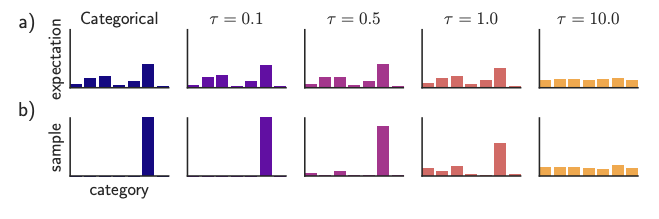

In [2]:
dist = RelaxedOneHotCategorical(torch.tensor([0.5]), probs=torch.tensor([0.1, 0.9, 0.3]))

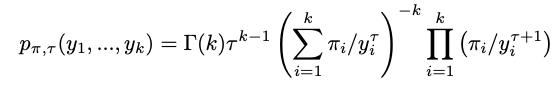

In [3]:
d.kl.kl_divergence(dist.base_dist._categorical, dist.base_dist._categorical)

tensor(0.)

In [4]:
from scipy.special import gamma
import numpy as np

In [5]:
# eq_prob = gamma(2) * 0.5 * (0.1 / sample_np[0] ** 0.5 + 0.9 / sample_np[1] ** 0.5) ** (-2) * (
#     (0.1 / sample_np[0] ** (0.5+1)) * (0.9 / sample_np[1] ** (0.5+1))
# )
# np.log(eq_prob)

In [6]:
samples = dist.sample(sample_shape=(100,))

In [7]:
dist.log_prob(samples)

tensor([ 4.2938,  3.6256,  3.4935,  1.1996,  9.3082,  6.4679,  1.6007,  7.1852,
         1.2178,  5.0243, 11.6992,  1.6718,  1.7653,  4.2115,  4.9080,  0.7998,
         3.0445,  1.8193, 12.4505,  7.3323,  2.6487,  9.0243,  1.9224,  5.3560,
        12.3304,  6.5617, 18.2834, -1.0683,  4.4008, -0.1033, 14.2884,  2.4004,
         8.4873,  1.0567,  3.4825,  3.5832,  5.3391,  2.0241,  6.4681,  9.4610,
         2.7534,  6.7828, -1.8408,  3.1817,  4.4857,  2.5933,  1.9765, 13.9314,
         4.1451,  3.7337,  1.7925,  4.7953, 19.3010,  5.4650,  9.3505,  0.5612,
         2.7842, -1.8645, 14.7761,  4.8763,  3.5769,  4.5137,  3.5601,  0.8606,
        -1.1199, -0.3121, -0.7543,  3.0115,  1.6004,  4.5019,  7.3502,  1.4538,
        10.8974,  2.8373,  4.7838,  6.2996,  3.5184, 10.9517, 15.0564, 12.4853,
         7.1673, -0.2218,  3.8203, 13.3647,  4.7616,  5.6211, 16.9876,  4.1984,
        -0.1950,  2.6059, 14.0481,  2.4443,  3.4004,  6.0766,  6.6663,  3.3727,
         1.8054, -0.7637,  4.1027,  3.22

In [8]:
dist = d.Categorical(probs=torch.tensor([0.5, 0.5]))

In [9]:
samples = dist.sample(sample_shape=(10, ))
samples

tensor([1, 0, 0, 0, 0, 0, 0, 1, 1, 1])

In [10]:
dist.log_prob(samples)

tensor([-0.6931, -0.6931, -0.6931, -0.6931, -0.6931, -0.6931, -0.6931, -0.6931,
        -0.6931, -0.6931])

## Distributions

In [2]:
import torch.distributions as d

OneHotCat = d.OneHotCategorical
RelaxedOneHotCat = d.relaxed_categorical.RelaxedOneHotCategorical

Ind = d.Independent
Normal = d.Normal

CB = d.ContinuousBernoulli

## Generative model

### Module for p(y)

In [385]:
class p_y_class(nn.Module):
    
    def __init__(self, y_dim):
        super().__init__()
        self.y_dim = y_dim
        self.logits = torch.ones(y_dim)
        
    def forward(self, head):
        if head == "one_hot_categorical":
            return OneHotCat(logits=self.logits)
        elif head == "gumbel_softmax":
            return RelaxedOneHotCat(logits=self.logits, temperature=torch.tensor([0.5]))
        else:
            raise ValueError(f"{head} is not a valid value for head.")

### Module for p(z|y)

In [386]:
class p_z_given_y_class(nn.Module):
    
    def __init__(self, y_dim, z_dim):
        super().__init__()
        self.y_dim = y_dim
        self.z_dim = z_dim
        self.shared = nn.Sequential(
            nn.Linear(y_dim, 500),
            nn.ReLU(),
            nn.Linear(500, 500),
            nn.ReLU()
        )
        self.mus = nn.Linear(500, z_dim)
        self.sigmas = nn.Sequential(
            nn.Linear(500, z_dim),
            nn.Softplus()
        )
        
    def forward(self, ys):
        ys = self.shared(ys)
        return Ind(Normal(self.mus(ys), self.sigmas(ys)), 1)

### Module for p(x|z)

In [428]:
class p_x_given_z_class(nn.Module):

    def __init__(self, x_dim, z_dim):
        super().__init__()
        self.x_dim = x_dim
        self.z_dim = z_dim
        self.lambdas = nn.Sequential(
            nn.Linear(z_dim, 500),
            nn.ReLU(),
            nn.Linear(500, 500),
            nn.ReLU(),
            nn.Linear(500, x_dim),
            nn.Sigmoid()
        )

    def forward(self, zs):
        return Ind(CB(self.lambdas(zs)), 1)
    
    

## Approximate posterior

### Module for q(y|x)

In [388]:
class q_y_given_x_class(nn.Module):
    
    def __init__(self, x_dim, y_dim):
        super().__init__()
        self.x_dim = x_dim
        self.y_dim = y_dim
        self.layers = nn.Sequential(
            nn.Linear(x_dim, 500),
            nn.ReLU(),
            nn.Linear(500, 500),
            nn.ReLU(),
            nn.Linear(500, y_dim)
        )
        
    def forward(self, xs, head):
        if head == "one_hot_categorical":
            return OneHotCat(logits=self.layers(xs))
        elif head == "gumbel_softmax":
            return RelaxedOneHotCat(logits=self.layers(xs), temperature=torch.tensor([0.5]))
        else:
            raise ValueError(f"{head} is not a valid value for head.")
            
    def sample_gumbel(self, shape, is_cuda=False, eps=1e-20):
        U = torch.rand(shape)
        if is_cuda:
            U = U.cuda()
        return -torch.log(-torch.log(U + eps) + eps)
    
    def gumbel_softmax_sample(self, logits, temperature):
        y = logits + self.sample_gumbel(logits.size(), logits.is_cuda)
        return torch.nn.functional.softmax(y / temperature, dim=-1)
    
    def rsample(self, xs, temperature=0.5):
        """
        ST-gumple-softmax
        input: [*, n_class]
        return: flatten --> [*, n_class] an one-hot vector
        """
        logits = self.layers(xs)
        y = self.gumbel_softmax_sample(logits, temperature)
        return y

### Module for q(z|x, y)

In [389]:
class q_z_given_x_y_class(nn.Module):

    def __init__(self, x_dim, y_dim, z_dim):
        super().__init__()
        self.z_dim = z_dim
        self.x_dim = x_dim
        self.shared = nn.Sequential(
            nn.Linear(x_dim + y_dim, 500),
            nn.ReLU(),
            nn.Linear(500, 500),
            nn.ReLU(),
        )
        self.mus = nn.Linear(500, z_dim)
        self.sigmas = nn.Sequential(
            nn.Linear(500, z_dim),
            nn.Softplus()
        )

    def forward(self, xs, ys):
        temp = self.shared(torch.cat([xs, ys], dim=1))
        return Ind(Normal(self.mus(temp), self.sigmas(temp)), 1)

## AEVB

In [390]:
import itertools
import torch.optim as optim

In [391]:
q_y_given_x = q_y_given_x_class(x_dim=28*28, y_dim=10)
q_y_given_x(torch.randn(32, 28*28), head="one_hot_categorical").mean.shape

torch.Size([32, 10])

In [429]:
# a = torch.stack([
#     d.kl.kl_divergence(post_over_zs, self.p_z_given_y(torch.eye(10)[y].unsqueeze(0))) 
#     for y in range(10)
# ]).T

# stuff = []
# for y in range(10):
#     ys = torch.eye(10)[y].unsqueeze(0).repeat(bs, 1)
#     zs = self.q_z_given_x_y(xs, ys).rsample()
#     fs = self.p_x_given_z(zs).log_prob(xs) \
#          + self.p_z_given_y(ys).log_prob(zs) \
#          + self.p_y().log_prob(ys) \
#          - self.q_z_given_x_y(xs, ys).log_prob(zs) \
#          - self.q_y_given_x(xs).log_prob(ys)
# stuff = torch.stack(stuff).T

In [430]:
q_z_given_x_y = q_z_given_x_y_class(z_dim=20, x_dim=28*28, y_dim=10)

In [431]:
torch.eye(10)

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

In [432]:
torch.eye(10)[torch.tensor(range(10)).repeat(3)]

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],


In [433]:
a = torch.tensor([
    [1, 2, 3],
    [4, 5, 6]
])

In [434]:
torch.tensor([1, 2, 3, 4, 5, 6, 7, 8]).reshape(2, 4).T

tensor([[1, 5],
        [2, 6],
        [3, 7],
        [4, 8]])

In [435]:
#         ys = self.q_y_given_x.rsample(xs)
#         post_over_zs = self.q_z_given_x_y(xs, ys)
#         zs = post_over_zs.rsample()
        
#         post_over_ys_hard = self.q_y_given_x(xs, head="one_hot_categorical")

#         fs = self.p_x_given_z(zs).log_prob(xs) \
#              - d.kl.kl_divergence(post_over_ys_hard, self.p_y(head="one_hot_categorical")) \
#              - d.kl.kl_divergence(post_over_zs, self.p_z_given_y(ys))
            
#         a = torch.stack([
#              d.kl.kl_divergence(post_over_zs, self.p_z_given_y(torch.eye(10)[y].unsqueeze(0))) for y in range(10)
#         ]).T

#         - (post_over_ys_hard.mean * a).sum(dim=1)
# 
#         post_over_ys = self.q_y_given_x(xs, head="gumbel_softmax")
#         ys = post_over_ys.rsample()
#         post_over_zs = self.q_z_given_x_y(xs, ys)
#         zs = post_over_zs.rsample()
    
#         fs = self.p_x_given_z(zs).log_prob(xs) \
#            + self.p_z_given_y(ys).log_prob(zs) \
#            + self.p_y(head="gumbel_softmax").log_prob(ys) \
#            - post_over_ys.log_prob(ys) \
#            - post_over_zs.log_prob(zs)

#         ys = torch.eye(10)[y].unsqueeze(0).repeat(xs.size(0), 1)
#         zs = self.q_z_given_x_y(xs, ys).rsample()
#         fs = self.p_x_given_z(zs).log_prob(xs) \
#              + self.p_y(head="one_hot_categorical").log_prob(ys) \
#              - self.q_y_given_x(xs, head="one_hot_categorical").log_prob(ys) \
#              - d.kl.kl_divergence(self.q_z_given_x_y(xs, ys), self.p_z_given_y(ys))
#         stuff.append(fs)
#         stuff = torch.stack(stuff).T

In [436]:
class AEVB():
    
    def __init__(self, x_dim, y_dim, z_dim, lr=1e-3):
        
        super().__init__()
        
        self.x_dim = x_dim
        self.y_dim = y_dim
        self.z_dim = z_dim
        
        # generative model
        
        self.p_y = p_y_class(y_dim)
        self.p_z_given_y = p_z_given_y_class(y_dim, z_dim)
        self.p_x_given_z = p_x_given_z_class(x_dim, z_dim)

        # approximate posterior
        
        self.q_y_given_x = q_y_given_x_class(x_dim, y_dim)
        self.q_z_given_x_y = q_z_given_x_y_class(x_dim, y_dim, z_dim)
        
        # optimizers
        
        self.opt = optim.Adam(
            itertools.chain(
                self.p_z_given_y.parameters(),
                self.p_x_given_z.parameters(),
                self.q_y_given_x.parameters(),
                self.q_z_given_x_y.parameters()
            ), 
            lr=lr
        )
        
    def step(self, xs, train):

        probs = self.q_y_given_x(xs, head="one_hot_categorical").mean

        bs = xs.size(0)
    
        ys = torch.eye(self.y_dim)[torch.tensor(range(self.y_dim)).repeat_interleave(bs)]
        xs = xs.repeat(self.y_dim, 1)
        post_over_zs = self.q_z_given_x_y(xs, ys)
        zs = post_over_zs.rsample()
        fs = self.p_x_given_z(zs).log_prob(xs) \
             + self.p_y(head="one_hot_categorical").log_prob(ys) \
             - self.q_y_given_x(xs, head="one_hot_categorical").log_prob(ys) \
             - d.kl.kl_divergence(post_over_zs, self.p_z_given_y(ys))
        fs = fs.reshape(self.y_dim, bs).T
        fs = (probs * fs).sum(dim=1)
        
        estimated_elbo = fs.mean()
        loss = - estimated_elbo
        
        if train:
            self.opt.zero_grad()
            loss.backward()
            self.opt.step()
        
        return float(estimated_elbo)
    
    def predict_cluster(self, xs):
        with torch.no_grad():
            return self.q_y_given_x(xs, head="one_hot_categorical").mean.argmax(dim=1)
    
    def generate(self, n, mode):
        with torch.no_grad():
            ys = self.p_y(head="one_hot_categorical").sample((n, ))
            zs = self.p_z_given_y(ys).sample()
            if mode == "mean":
                xs = self.p_x_given_z(zs).mean
            elif mode == "sample":
                xs = self.p_x_given_z(zs).sample()
            elif mode == "param":
                xs = self.p_x_given_z.lambdas(zs)
            return xs
    
    def generate_from_cluster(self, n, cluster_index, mode):
        with torch.no_grad():
            ys = torch.eye(self.y_dim)[cluster_index].repeat(n, 1)
            zs = self.p_z_given_y(ys).sample()
            if mode == "mean":
                xs = self.p_x_given_z(zs).mean
            elif mode == "sample":
                xs = self.p_x_given_z(zs).sample()
            elif mode == "param":
                xs = self.p_x_given_z.lambdas(zs)
            return xs
    
#     def save(self):
#         torch.save(self.state_dict(), "gmvae.pth")

#     def load(self):
#         self.load_state_dict(torch.load("gmvae.pth", map_location=torch.device("cpu")))

In [437]:
aevb = AEVB(x_dim=28*28, y_dim=10, z_dim=64)

In [438]:
data = torch.ones(5, 28*28).clip(0, 1)

In [439]:
aevb.step(data, train=True)

-2.1962082386016846

## Data

In [440]:
import numpy as np
from keras.datasets.mnist import load_data
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

In [441]:
(x_train, y_train), (x_test, y_test) = load_data()

x_train = x_train[np.where((y_train == 0) | (y_train == 2) | (y_train == 4))]
y_train = y_train[np.where((y_train == 0) | (y_train == 2) | (y_train == 4))]

x_test = x_test[np.where((y_test == 0) | (y_test == 2) | (y_test == 4))]
y_test = y_test[np.where((y_test == 0) | (y_test == 2) | (y_test == 4))]

x_train = x_train + np.random.uniform(low=0, high=1, size=x_train.shape)
x_train = x_train / 256
x_train = x_train.reshape(-1, 28*28)

x_test = x_test + np.random.uniform(low=0, high=1, size=x_test.shape)
x_test = x_test / 256
x_test = x_test.reshape(-1, 28*28)

x_train[x_train > 0.5] = 1 
x_train[x_train <= 0.5] = 0

x_test[x_test > 0.5] = 1 
x_test[x_test <= 0.5] = 0

train_ds = TensorDataset(torch.from_numpy(x_train).float())
train_dl = DataLoader(train_ds, batch_size=64)

test_ds = TensorDataset(torch.from_numpy(x_test).float(), torch.from_numpy(y_test).long())
test_dl = DataLoader(test_ds, batch_size=1000, shuffle=False)

x_test_torch = torch.from_numpy(x_test).float()

In [442]:
np.unique(y_train)

array([0, 2, 4], dtype=uint8)

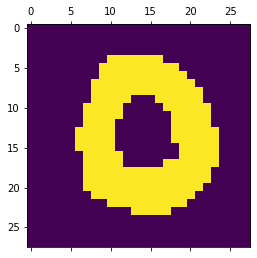

In [443]:
plt.matshow(x_test[99].reshape(28, 28))
plt.show()

In [18]:
import pandas as pd
import numpy as np

In [23]:
x_train = pd.read_csv("painted_data.csv")[["x", "y"]].to_numpy()

(array([385.,   0., 451.,   0.,   0., 422.,   0., 344.,   0., 501.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

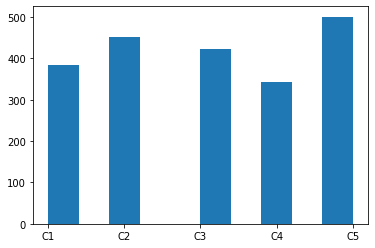

In [22]:
plt.hist((pd.read_csv("painted_data.csv")[["Class"]].to_numpy().flatten()))

## Training

In [444]:
from scipy.optimize import linear_sum_assignment
def cluster_acc(Y_pred, Y):
    Y_pred, Y = np.array(Y_pred), np.array(Y)
    assert Y_pred.size == Y.size
    D = max(Y_pred.max(), Y.max())+1
    w = np.zeros((D,D), dtype=np.int64)
    for i in range(Y_pred.size):
        w[Y_pred[i], Y[i]] += 1
    row, col = linear_sum_assignment(w.max()-w)
    return sum([w[row[i],col[i]] for i in range(row.shape[0])]) * 1.0/Y_pred.size

In [445]:
cluster_acc([1, 2, 3], [3, 2, 1])

1.0

In [446]:
from tqdm import tqdm

In [447]:
aevb = AEVB(x_dim=28*28, y_dim=3, z_dim=20)
aevb.predict_cluster(x_test_torch).numpy()

array([2, 0, 0, ..., 2, 1, 0])

In [449]:
aevb = AEVB(x_dim=28*28, y_dim=3, z_dim=64)

test_elbos = []

test_acc = cluster_acc(aevb.predict_cluster(x_test_torch).numpy(), y_test)
print(test_acc)

for epoch in range(100):
    
    print(epoch)
    
    for (xb, ) in tqdm(train_dl):
        aevb.step(xb, train=True)
    
    test_elbo = aevb.step(x_test_torch, train=False)
    test_acc = cluster_acc(aevb.predict_cluster(x_test_torch).numpy(), y_test)
    
    print(test_elbo, test_acc)

aevb.save()
    
with open("test_elbos", "wb") as fp:
    pickle.dump(test_elbos, fp)

0.35404141616566465
0


100%|█████████████████████████████████████████| 277/277 [00:06<00:00, 40.32it/s]


1448.9747314453125 0.9114896459585838
1


 41%|████████████████▊                        | 114/277 [00:02<00:03, 42.33it/s]


KeyboardInterrupt: 

## Reconstruction

In [412]:
import matplotlib.pyplot as plt

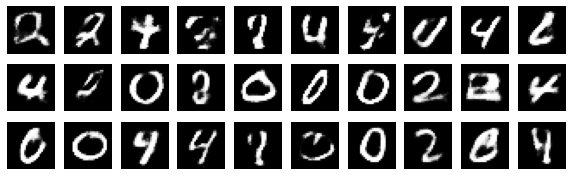

In [419]:
torch.manual_seed(10)
gens = aevb.generate(n=30, mode="mean").detach()
plt.figure(figsize=(10, 3))
for i in range(1, 31):
    plt.subplot(3, 10, i)
    plt.imshow(gens[i-1].reshape(28, 28), cmap='gray')
    plt.axis('off')
plt.show()
    #plt.savefig("vae_mnist_gens_param.pdf", bbox_inches='tight',pad_inches = 0)

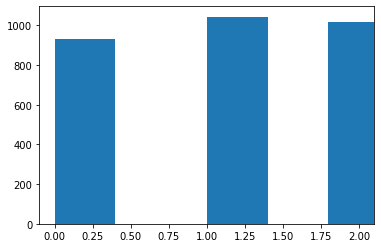

In [420]:
plt.hist(aevb.predict_cluster(x_test_torch).numpy(), width=0.4)
plt.show()

## Generation per category

In [421]:
def generate_from_cluster(self, n, cluster_index, mode):
    with torch.no_grad():
        ys = torch.eye(self.y_dim)[cluster_index].repeat(n, 1)
        zs = self.p_z_given_y(ys).sample()
        if mode == "mean":
            xs = self.p_x_given_z(zs).mean
        elif mode == "sample":
            xs = self.p_x_given_z(zs).sample()
        elif mode == "param":
            xs = self.p_x_given_z.lambdas(zs)
        return xs

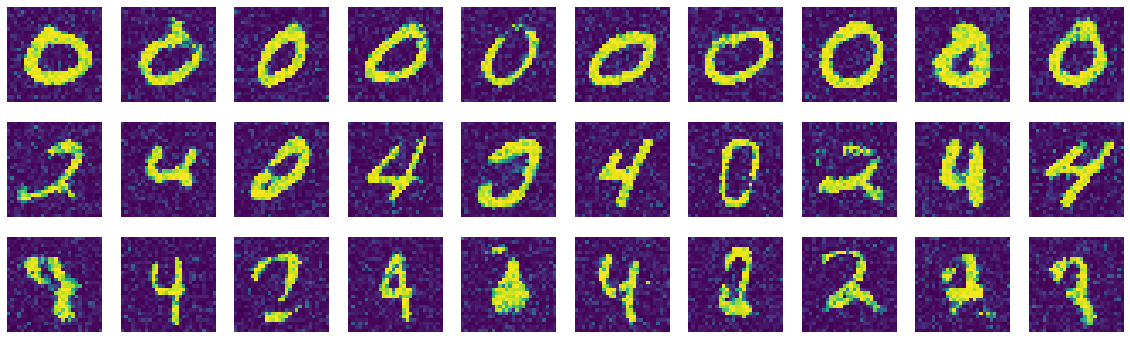

In [427]:
torch.manual_seed(42)
plt.figure(figsize=(20, 6))
for row_index in range(3):
    gens = generate_from_cluster(aevb, n=10, cluster_index=row_index, mode="sample").detach()
    for col_index in range(10):
        plt.subplot(3, 10, row_index * 10 + col_index + 1)
        plt.imshow(gens[col_index].reshape(28, 28), cmap="viridis")
        plt.axis('off')
plt.show()
    #plt.savefig("vae_mnist_gens_param.pdf", bbox_inches='tight',pad_inches = 0)